# Generative AI Model From Scratch

A Machine Learning model is used to make predictions based on historical data. Similarly, a Generative AI model creates new original data by learning from the historical data.

Building a generative AI model from scratch involves a dual-network setup consisting of a generator and a discriminator, unlike a typical machine learning model that usually involves a single predictive model.

In generative AI, the generator creates new data samples from random noise, while the discriminator evaluates these samples against real data to classify them as real or fake. The two networks are trained in tandem through an adversarial process where the generator aims to improve its ability to produce realistic outputs, and the discriminator enhances its accuracy in distinguishing between genuine and generated data.

**Generative Adversarial Networks (GANs)** consist of two neural networks:

**Generator**: Generates new data samples.

**Discriminator**: Evaluates whether a given data sample is real (from the training data) or fake (generated by the generator).

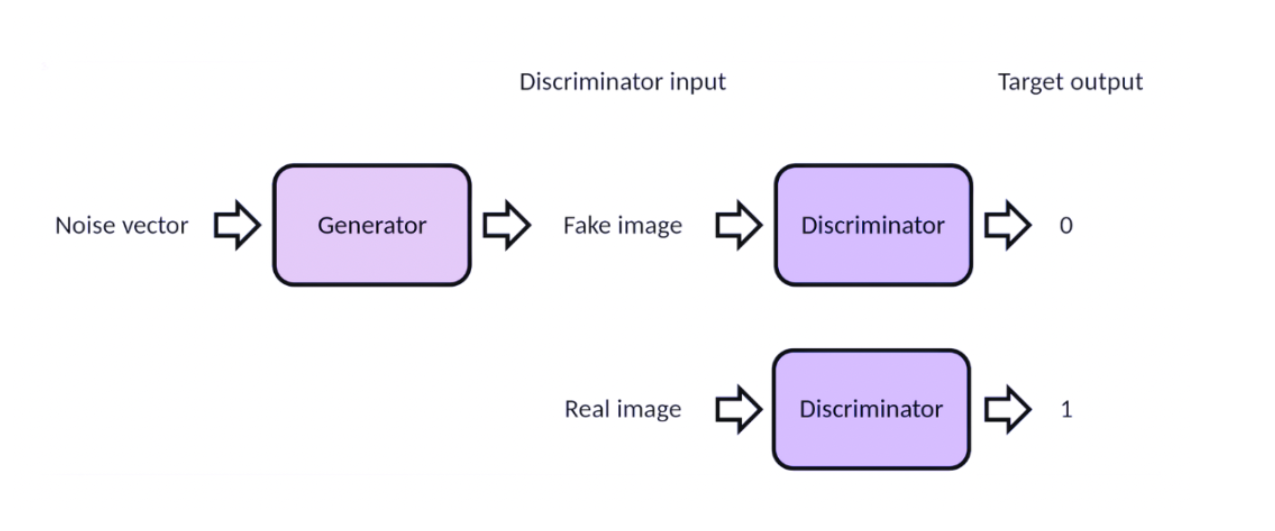

The two networks are trained together in a zero-sum game: the generator tries to fool the discriminator, while the discriminator aims to accurately distinguish real from fake data.

A GAN consists of the following key components:

**Noise Vector**: A random input vector fed into the generator.

**Generator**: A neural network that transforms the noise vector into a data sample.

**Discriminator**: A neural network that classifies input data as real or fake.

MNIST dataset is used for building a generative AI model from scratch since the data is large enough and easy to load.

In [1]:
# Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

(X_train, _), (_, _) = mnist.load_data()

In [2]:
X_train.shape

(60000, 28, 28)

## Building a Generator network

The generator network transforms a random noise vector into a data sample. A simple feed-forward network is used with several layers.

In [3]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim = 100)) # 100-dimensional noise vector as input
    model.add(LeakyReLU(alpha = 0.2)) 
    model.add(BatchNormalization(momentum = 0.8)) # normalizes the outputs of the previous layers to stabilize training and speed up convergence
    model.add(Dense(512)) # expanding dimensions of the output
    model.add(LeakyReLU(alpha = 0.2)) # introducing non-linearity
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(784, activation = 'tanh')) # scales the output to the range [-1,1], which is suitable for GANs when the image data is normalized to this range
    model.add(Reshape((28,28,1))) # represents a 28x28 grayscale image (1 channel)
    return model

generator = build_generator()

D:\Sehaj\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\Sehaj\anaconda\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Building a Discriminator Network

The discriminator network will classify input images as real or fake. It will be a binary classifier that outputs the probability of an image being real.

In [4]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(1, activation = 'sigmoid')) # produces an output in the range [0,1]
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer = Adam(0.0002, 0.5), loss ='binary_crossentropy', metrics = ['accuracy'])

D:\Sehaj\anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compiling and Training the GAN to build a Generative AI Model to Generate Images

In [7]:
""" Combining the generator and discriminator to train our GenAI model to generate image.
During training, the discriminator will be trained to distinguish real from fake images, while the generator will be trained to produce images that 
fool the discriminator. """

discriminator.trainable = False # to ensure only the generator is updated when training the GAN

# Creating the GAN model
gan_input = Input(shape = (100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image) 
gan = Model(gan_input, gan_output)

gan.compile(optimizer = Adam(0.0002, 0.5), loss = 'binary_crossentropy')

def train_gan(epochs, batch_size = 128):
    X_train, _ = mnist.load_data()
    X_train = (X_train[0].astype(np.float32) - 127.5) / 127.5 # normalizes pixel values to the range [-1,1], matching the generator's output activation 
    # function tanh
    X_train = np.expand_dims(X_train, axis = 3) # expands dimensions to add a channel axis (shape becomes (n,28,28,1))

    # defining real and fake labels
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size) # Randomly samples a batch of real images from the dataset
        real_images = X_train[idx] # Randomly samples a batch of real images from the dataset
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise) # Generates a batch of fake images using random noise and the generator.

        # Training the discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, real) 
        d_loss_fake = discriminator.train_on_batch(generated_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Calculates the discriminator's loss as the average of real and fake losses

        # Train the generator via the GAN
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_images(epoch)

In [12]:
discriminator.compile(
    optimizer=Adam(0.0002, 0.5), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
def save_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    generated_images = generator.predict(noise)
    
    generated_images = 0.5 * generated_images + 0.5
    
    fig, axs = plt.subplots(r, c)
    count = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    fig.savefig(f"gan_images_{epoch}.png")
    plt.close()

train_gan(epochs=10000, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0 [D loss: 2.6255269050598145, acc.: 1.9016388803720474] [G loss: 0.10650317370891571]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2